# Sequential QFT

The sequential QFT algorithm [1] allows for the computation of the QFT in a much more efficient way. In particular, this algorithm is useful when computing a QFT is the last step prior to making a measurement. 

As explained in [1], the subsequent controlled rotations that take place in the regular QFT algorithm [2,3] are controlled classically here. In the same order as for the regular QFT, the action on qubit $k$ corresponds to

\begin{equation}
|0\rangle_{k} \longrightarrow \frac{|0\rangle_{k} + |1\rangle_{k}}{\sqrt{2}} \qquad \qquad \qquad |1\rangle_{k} \longrightarrow e^{i2 \pi \phi_{k}} \frac{|0\rangle_{k} - |1\rangle_{k}}{\sqrt{2}},
\end{equation}

followed by a measurement of the qubit. The angles obey $\phi_{k} = \frac{\phi_{k-1}}{2} + \frac{c_{n-(k-1)}}{4}$, with $n$ the number of qubits, $\phi_{0} = 0$ and $c_{k} = 0,1$ the measurement outcome of qubit $k$. The reason for the the measurent index in $c_{n-k}$ to be reversed with respect to the angle index is because in the sequential QFT algorithm, the qubits are ''clasically swapped'', i.e. we revert the order in the classical bits.  Note that the transition into a superposition state (i.e. the application of a Hadamard gate) is independent of the measurement outcome, as in the regular QFT algorithm. Each measurement is stored in a classical bit, which can be accessed at each instance to determine the rotation angle $\phi_{k}$, which can be recasted as $\phi_{k} = \sum_{j=0}^{k-1} \frac{c_{n-j}}{2^{k+1-j}}$. 

Let us now point at the most interesting aspect of the sequential QFT, which is that it can be performed by using a single qubit register! Simply, all one has to do is reset the qubit to $|0\rangle$ after performing each measurment and proceed as if we were acting on the subsequent qubit. This achieved by adding one extra classical bit which controls the action of an X gate on the qubit if the measurmeent outcome is $|1\rangle$. The precision of this sequential QFT for algorithms like phase estimation then follow from the amount of classical registers we use, i.e. the amount of times we measure and reset the qubit.

In the following, we show the sequential method is equivalent to the regular QFT by going back and forth into Fourier space using a different algorithm for each transformation. Next, we show how one can perform Quantum Phase Estimation using only a single qubit perform pahse encoding and an inverse QFT.

Refs.:

[1] Robert B. Griffiths and Chi-Sheng Niu - Phys. Rev. Lett. 76, 3228 (1998)

[2] Qiskit tutorial notes: https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html

[3] Nielsen and Chuang - Quantum computation and quantum information

In [167]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

import numpy as np
pi = np.pi

import pandas as pd
from fractions import Fraction
from math import gcd
from numpy.random import randint
import timeit

%matplotlib inline 
from matplotlib import pyplot as plt

### Definition of regular Quantum Fourier Transform

In [207]:
def qft_rot(circuit,nq,inverse):
    ''' First part of the Quantum Fourier Transform. This function performs rotations 
    on a specific target qubit, which are controlled by remaining qubits that have not 
    been rotated yet. This is therefore performed recursively in order to progressively 
    reduce the number of qubits affected by the operation. The particular order of operation 
    has been set such that it follows the notation order in Qiskit. The target qubit is 
    thus the last one in the circuit and the function recursively moves upwards.
      
    Args:
        -circuit: Circuit on which the gates act
        -nq: Number of qubits in the circuit.
        -inverse: If False, regular qft is computed. If True, inverse qft is computed.
        '''
    # The parameter m sets the sign of the rotation angles
    if inverse:
        m = -1
    else:
        m = 1

    # If all qubits have been acted on return the circuit
    if nq == 0:        
        return circuit
    
    # Reduce by one the number of qubits in order to recursevely move through the circuit
    nq-=1
    
    # Act with a Hadamard gate on the target qubit
    circuit.h(nq)
    
    # Controlled rotations on the target qubit, with each one of the remaining qubits as controls
    for q in range(nq):
    
        circuit.cu1(m*2*pi/2**(nq+1-q),q,nq)
    
    # Recursively call the function to cover the entire circuit
    return qft_rot(circuit,nq,inverse)




def qft_swaps(circuit,nq):
    '''Second part of the Quantum Fourier transform. This function swaps qubits 
    paired from top and bottom towards the middle.
      
    Args:
        -circuit: Circuit on which the gates act
        -nq: Number of qubits in the circuit.
    '''
       
    # Swapping of each pair
    for q in range(nq//2):       
        circuit.swap(q,nq-1-q)
        
    return circuit



def qft(circuit,nq, inverse = False):
    '''Quantum Fourier Transform. The function is split into a series of controlled 
    rotations and swap operations. See Qiskit textbook section about QFT for details.
      
    Args:
        -circuit: Circuit on which the gates act
        -nq: Number of qubits in the circuit.
        -inverse: If False, regular qft is computed. If True, inverse qft is computed.
    ''' 
    # Rotations on the qubits
    circuit = qft_rot(circuit,nq,inverse)
    
    # Qubit swaps
    circuit = qft_swaps(circuit,nq)
    
    return circuit

## Validity of sequential QFT on several qubits

For a specific initial state, we perform a regular QFT, and then an inverse QFT using the sequential method, thus proving its validity.

In [12]:
def encode(circuit,nq,NQ,num):
    '''Encoding of a binary number into a quantum register using Qiskit's convention.
    
    Args:
        -circuit: Circuit we are encoding the number into.
        -nq: Number of qubits in the circuit.
        -NQ: reference value determining where in the register we are 
        encoding the number.
        -num: Binary number to encode.
    '''
    
    for q in range(nq):
        # Flip qubits according to the number
        if num[q] == '1':
            # Encode the number from NQ backwards into 
            # the nq qubits to respect Qiskit's convention
            circuit.x(NQ-1-q)
    
    return circuit

In [244]:
def sequential_qft(circuit,cl_reg,nq,inverse = False):
    ''' Sequential QFT on multiple qubits.
    
    Args:
        -circuit: Circuit on which to apply the sequential QFT.
        -cl_reg: Classical register of the circuit.
        -nq: Number of qubits in the circuit and number of measurements we perform.
        -inverse: If False, regular qft is computed. If True, inverse qft is computed.
    '''
    
    # The parameter m sets the sign of the rotation angles
    if inverse:
        m = -1
    else:
        m = 1
    
    # On each qubit we perform a rotation and act with a Hadamard gate according 
    # to the measurements on the previous qubits. Gates act from bottom to top
    # to satisfy Qiskit's convention
    for q in range(nq):
        
        for k in range(2**q):
            circuit.rz(m*2*pi*k/2**(q+1),nq-1-q).c_if(cl_reg,k)
    
        circuit.h(nq-1-q)
        circuit.measure(nq-1-q,cl_reg[q])
    
    return circuit

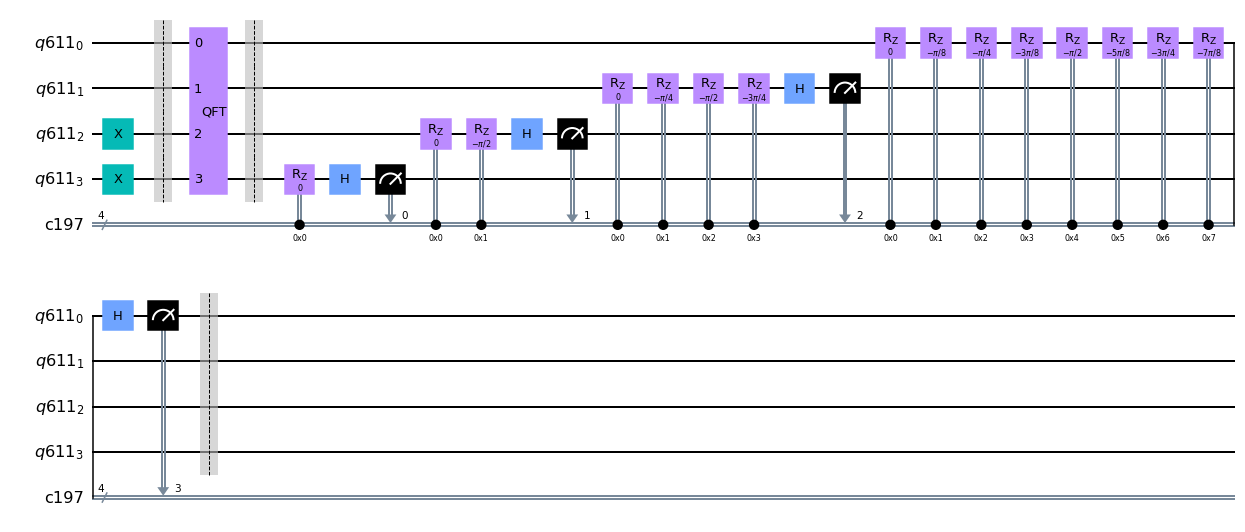

In [245]:
# Number to encode on the quantum register
number = 12
nq = len(format(number,'b'))

qr = QuantumRegister(nq)
cr = ClassicalRegister(nq)

circ = QuantumCircuit(qr,cr)

# Encode the number on the quantum register
circ = encode(circ,nq,nq,format(number,'b'))
circ.barrier()

# Perform regular QFT
qft_gate = qft(QuantumCircuit(nq),nq)
qft_gate.name = 'QFT'
circ.append(qft_gate,qr)
circ.barrier()

# Perform sequential inverse QFT
circ = sequential_qft(circ,cr,nq,inverse = True)
circ.barrier()

circ.draw(output = 'mpl')

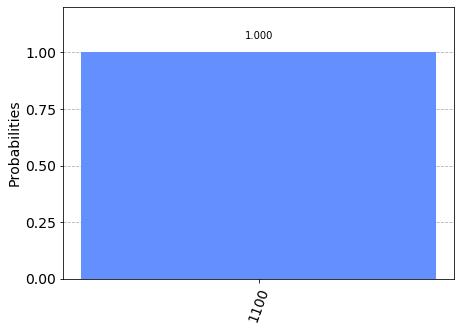

In [235]:
# Execute the circuit using a classical simulator
sim = Aer.get_backend('qasm_simulator')
result = execute(circ,backend = sim, shots = 10000).result()
plot_histogram(result.get_counts())

We retrieve the initally encoded state, thus showing the validity of the sequential QFT.

## Quantum Phase Estimation with Sequential QFT

Here we demonstrate how one can also perform Quantum Phase Estimation using the sequential QFT, taking advantage that the inverse QFT is the last step in the algorithm, prior to the measurements.

In [89]:
def phase_encoding(circuit,nq,th):
    ''' This function applies nq rotations on the ancilla qubit controlled by each one of 
    the qubits in the main register. This encodes the phase on the states via phase kickback 
    on the qubits that act as controlls.
    
    Args:
        -circuit: Circuit on which the phase in encoded
        -nq: Number of qubits in the circuit
        -th: Angle we encode in the circuit
    '''
    
    # Perform rotations of decreasing angle
    for q in range(nq):
        circuit.cu1(th*2**(nq-1-q),nq-1-q,nq)
        
    return circuit
    

In [267]:
def sequential_qpe(nq,theta):
    
    # Total number of qubits in the system includes an extra ancilla 
    # prepared in the corresponding eigenstate
    qr = QuantumRegister(nq+1)
    cr = ClassicalRegister(nq)

    circuit = QuantumCircuit(qr,cr)

    # Initialize qubits in main register in a superposition state
    for qubit in range(nq):
        circuit.h(qubit)
    
    # Initialize ancilla state in the excited state
    circuit.x(nq)
    circuit.barrier()

    # Encode the phase from ancilla in the main register
    circuit = phase_encoding(circuit,nq,theta)
    circuit.barrier()

    # Apply Sequential inverse QFT
    circuit = sequential_qft(circuit,cr,nq,inverse = True)
    
    return circuit

In [251]:
# Phase we want to encode 
th = 1/7 
angle = 2*pi*th

# Number of qubits in the main register
nq = 10  

# Sequential Quantum Phase Estimation
qpe_circ = sequential_qpe(nq,angle)    

In [252]:
sim = Aer.get_backend('qasm_simulator')
qpe_result = execute(qpe_circ, backend = sim, shots = 2048).result()
plot_histogram(qpe_result.get_counts())

# Retrieve most frequently measured state
qpe_mf = qpe_result.get_counts().most_frequent()

# Use this state to retrieve theta
theta = int(qpe_mf,2)/2**nq

print('The measured value is {} with an error of {}'.format(theta,abs(theta-th)))

The measured value is 0.142578125 with an error of 0.0002790178571428492


As we can see, the algorithm allows for accurate phase estimation. Higher accuracy is obtained upon increasing the number of qubits in the main register, in accordance with the original algorithm. This is shown below.

Text(0, 0.5, '$\\theta_{estimate}$')

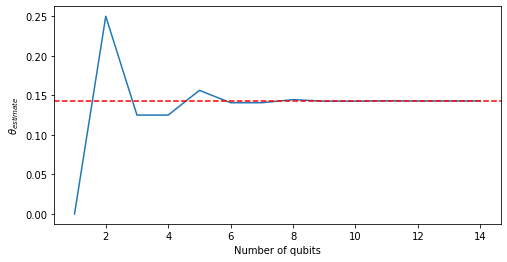

In [298]:
th = 1/7 # Phase we want to encode 
angle = 2*pi*th

phases = [] # List of estimated phases

nqubits = list(range(1,15)) # Number of qubits in the main register

sim = Aer.get_backend('qasm_simulator')

# Repeat the simulation for increasing size of main register
for n in nqubits:
    
    # Deifine and execute circuit
    qpe_circ = sequential_qpe(n,angle)
    qpe_result = execute(qpe_circ, backend = sim, shots = 4096).result()
    
    # Extrapolate value of theta from most frequently measured state
    qpe_mf = qpe_result.get_counts().most_frequent()
    
    # Add to the phases list the measured value 
    phases.append(int(qpe_mf,2)/2**(n))
    

# Plot the results and the real value in a horizontal line
fig = plt.figure(figsize=(8, 4), frameon=False)

plt.plot(nqubits,phases)
plt.axhline(y=angle/(2*pi), color='r', linestyle='--')

plt.xlabel('Number of qubits')
plt.ylabel(r'$\theta_{estimate}$')

## Quantum Phase Estimation using Sequential QFT on a single qubit

We now demonstrate that phase estimation can be carried out using a single qubit in the main register. To increase the accuracy of our estimation it is now required that we perform an increasing amount of measurements, including expanding the size of our classical register accordingly. Given that classical resources are more abundant and robust, this imposes a much affordable constraint that increasing the amount of qubits.

In [274]:
def sequential_qpe_oneQ(n_meas,theta):
    
    # The number of qubits necessary to encode the phase here is only 1
    nq = 1

    # Total number of qubits in the system includes an extra ancilla 
    # prepared in the corresponding eigenstate
    q_reg = QuantumRegister(nq+1)

    # This classical register stores the number of measurements from 
    # which the phase is estimated later
    cl_reg = ClassicalRegister(n_meas)

    # This classical register sequentially stores the same measurements
    # as the other, but it is only used as a control to reset the qubit
    signal = ClassicalRegister(1)

    circuit = QuantumCircuit(q_reg,cl_reg,signal)
    
    # Initialize ancilla state in the excited state
    circuit.x(nq)
    circuit.barrier()


    # Apply Sequential inverse QFT
    for q in range(n_meas):
    
    
        circuit.x(0).c_if(signal,1)
        circuit.h(0)
        circuit.cu1(theta*2**(n_meas-1-q),0,1)
    
        for k in range(2**q):
            circuit.rz(-2*pi*k/2**(q+1),0).c_if(cl_reg,k)
    
        circuit.h(0)
        circuit.measure(0,cl_reg[q])
        circuit.measure(0,signal)
    
    return circuit

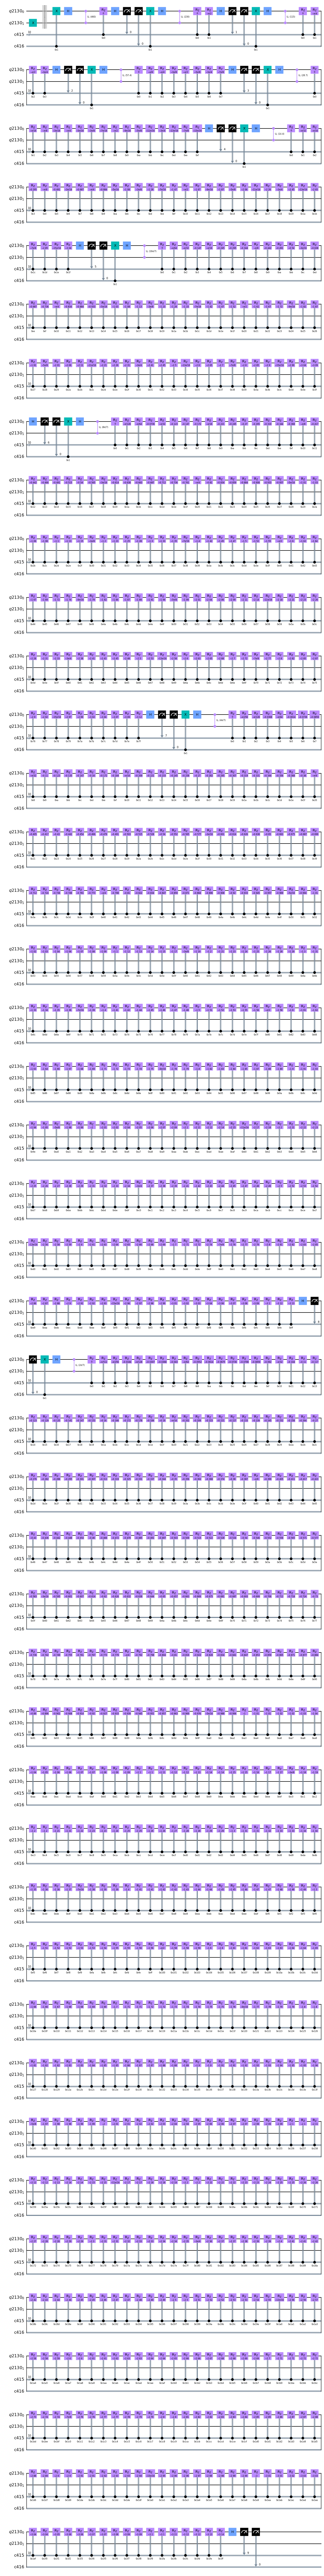

In [294]:
# Phase we want to encode 
th = 1/7 
angle = 2*pi*th

# Number of times we want to measure
n_measurement = 10 

qpe_circ = sequential_qpe_oneQ(n_measurement,angle)   
    
qpe_circ.draw(output = 'mpl')

In [295]:
sim = Aer.get_backend('qasm_simulator')
qpe_result = execute(qpe_circ, backend = sim, shots = 2048).result()
plot_histogram(qpe_result.get_counts())

# Retrieve most frequently measured state
qpe_mf = qpe_result.get_counts().most_frequent().split()
qpe_mf = ''.join(qpe_mf)

# Using the state to retrieve theta
theta = int(qpe_mf,2)/2**n_measurement

print('The measured value is {} with an error of {}'.format(theta,abs(theta-th)))

The measured value is 0.142578125 with an error of 0.0002790178571428492


Remarkably, we observe how it is possible to perform quantum phase estimation with this semiclassical method using only one qubit to perform the inverse qft and the measurements sequentially. Below, we show what is the scaling of the accuracy with respect to the number of measurements we perform.

Text(0, 0.5, '$\\theta_{estimate}$')

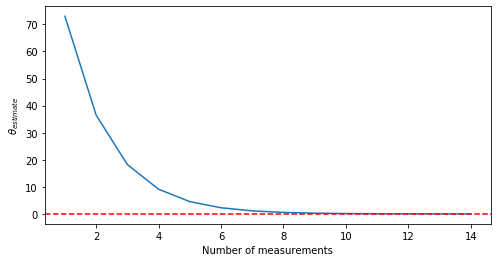

In [297]:
th = 1/7 # Phase we want to encode 
angle = 2*pi*th

phases = [] # List of estimated phases

nqubits = list(range(1,15)) # Number of measurements we perform

sim = Aer.get_backend('qasm_simulator')

# Repeat the simulation for increasing number of measurements
for n in nqubits:
    
    # Deifine and execute circuit
    qpe_circ = sequential_qpe_oneQ(n,angle)
    qpe_result = execute(qpe_circ, backend = sim, shots = 4096).result()
    
    # Extrapolate value of theta from most frequently measured state
    qpe_mf = qpe_result.get_counts().most_frequent().split()
    qpe_mf = ''.join(qpe_mf)
    
    # Add to the phases list the measured value 
    phases.append(int(qpe_mf,2)/2**(n))
    

# Plot the results and the real value in a horizontal line
fig = plt.figure(figsize=(8, 4), frameon=False)

plt.plot(nqubits,phases)
plt.axhline(y=angle/(2*pi), color='r', linestyle='--')

plt.xlabel('Number of measurements')
plt.ylabel(r'$\theta_{estimate}$')

In contrast with the previous cases, we observe that the price of using smaller resources in terms of qubits needs to be compensated in the form of measurements - around a dozen to obtain an accurate value. Nevertheless, this single qubit simplification is very convenient when state from which the phase to be extracted requires the use of a large amount of qubits. This is the case, for exmaple, for Shor's algorithm, where using a sequential QFT becomes an highly convenient technique.